In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform


env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax
#jax.config.update("jax_enable_x64", True)
sys.path.append('../synax/')

import synax,bfield
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const

2024-07-22 15:27:43.892437: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


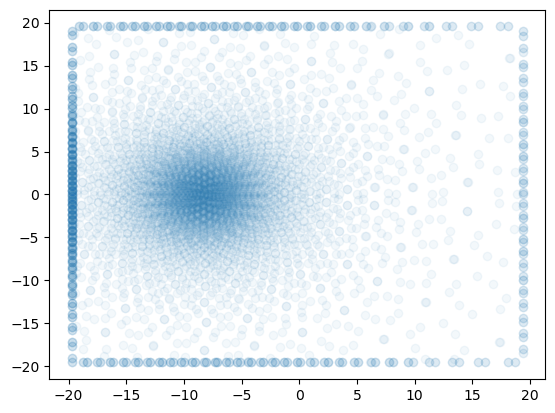

In [3]:
nside = 64
num_int_points = 512
obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi,num_int_points=num_int_points))
n_pixs = np.arange(0,12*nside**2)
theta,phi = hp.pix2ang(nside,n_pixs)
poss,dls,nhats = obtain_vmap(theta,phi)
nhats.shape
plt.scatter(poss[::10,0,500],poss[::10,1,500],alpha=0.05)

In [4]:
@jax.jit
def C_page(x:float,y:float,z:float,C0:float = 1.,hr:float=5,hd:float=1):
    #x = x
    #z = z
    #c = (x**2+y**2+z**2)/jnp.max(jnp.array([x**2+y**2+z**2,9.]))+1e-7
    
    return C0*jnp.exp(-jnp.sqrt(x**2+y**2)/hr)/jnp.cosh(z/hd)**2#*(1-jnp.floor(c))

C_earth = C_page(-8.3,0,0.06)
C_page_vmap = jax.vmap(lambda x,y,z:C_page(x,y,z))

C_field = C_page_vmap(poss[:,0,:].reshape(-1),poss[:,1,:].reshape(-1),poss[:,2,:].reshape(-1)).reshape((-1,num_int_points))*4.0e1/C_earth

In [5]:
nx,ny,nz = 256,256,64

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

(256, 256, 64)

In [6]:
dtype = np.float64
tereg = np.fromfile('../../SyncEmiss/tereg.bin', dtype=dtype).reshape((256,256,64))#.reshape((64,4,64,4,16,4)).mean(axis = (1,3,5))
TE_field = tereg
interp_TE_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,TE_field,method='linear',extrap=True))
TE_field_interp = interp_TE_3d(poss)

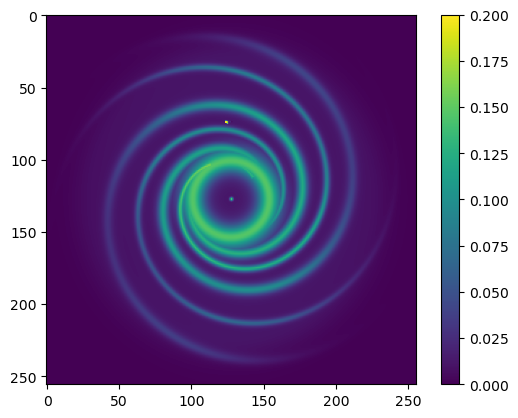

In [7]:
plt.imshow(TE_field[:,:,32],vmax=0.2)
plt.colorbar()

In [8]:
lsa_params = {"b0":1.2,
               "psi0":27.0*np.pi/180,
               "psi1":0.9*np.pi/180,
               "chi0":25.0*np.pi/180}

B_generator = bfield.B_lsa((poss[:,0,:].reshape(-1),poss[:,1,:].reshape(-1),poss[:,2,:].reshape(-1)))
lsa_params

{'b0': 1.2,
 'psi0': 0.47123889803846897,
 'psi1': 0.015707963267948967,
 'chi0': 0.4363323129985824}

In [9]:
#const
q_converter = 1/(4*np.pi*const.epsilon_0)**0.5

B_converter = (4*np.pi/const.mu_0)**0.5

freq_irrelavent_const = (const.e*q_converter)**3/(const.electron_mass**2*const.speed_of_light**4)/(2*np.pi)*1e6*1e-4*B_converter*1e19*3.08 # moves 1/cm^3 = 1e6 1/m^3 1 gauss = 1e-4 tesla 1 kpc = 3.08e19 m here.

freq_irrelavent_const

810407283.1937842

In [10]:
%%time

def lsa_model(lsa_params,freq):
    B_field = B_generator.B_field(lsa_params).reshape((-1,num_int_points,3))
    B_los = -1*((nhats[:,jnp.newaxis,:]*B_field)).sum(axis=-1)
    phis = freq_irrelavent_const*TE_field_interp*B_los
    sinb = nhats[...,2]
    cosb = jnp.sqrt(1-sinb**2)
    cosl = nhats[...,0]/cosb
    sinl = nhats[...,1]/cosb

    Bz = B_field[...,2]
    By = B_field[...,1]
    Bx = B_field[...,0]
    tanchi0 = (Bz*cosb[:,jnp.newaxis]-sinb[:,jnp.newaxis]*(cosl[:,jnp.newaxis]*Bx+By*sinl[:,jnp.newaxis]))/(Bx*sinl[:,jnp.newaxis]-By*cosl[:,jnp.newaxis])
    chi0 = jnp.arctan(tanchi0)
    phi_int = jnp.cumsum(phis,axis=1)*dls[:,jnp.newaxis]

    fd = phi_int*const.c**2/(freq**2*1e18)
    fd_q = jnp.cos(2*fd+2*chi0)
    fd_u = jnp.sin(2*fd+2*chi0)


    B_field_square = (B_field**2).sum(axis=-1)

    B_trans = (B_field_square-B_los**2)**0.5

    emiss = synax.sync_emiss_P(freq,B_trans,C_field,spectral_index=3.)
    Sync_Q_int = (emiss*fd_q).sum(axis=-1)*dls
    Sync_U_int = (emiss*fd_u).sum(axis=-1)*dls
    
    return Sync_Q_int,Sync_U_int

lsa_model_vmap = jax.vmap(lsa_model,in_axes = (None,0) )

CPU times: user 23 µs, sys: 12 µs, total: 35 µs
Wall time: 39.3 µs


In [11]:
%%time

freqs = jnp.linspace(2.4,4.4,2)
Sync_Q_ints,Sync_U_ints = lsa_model_vmap(lsa_params,freqs)

CPU times: user 6.43 s, sys: 2.1 s, total: 8.52 s
Wall time: 7.98 s


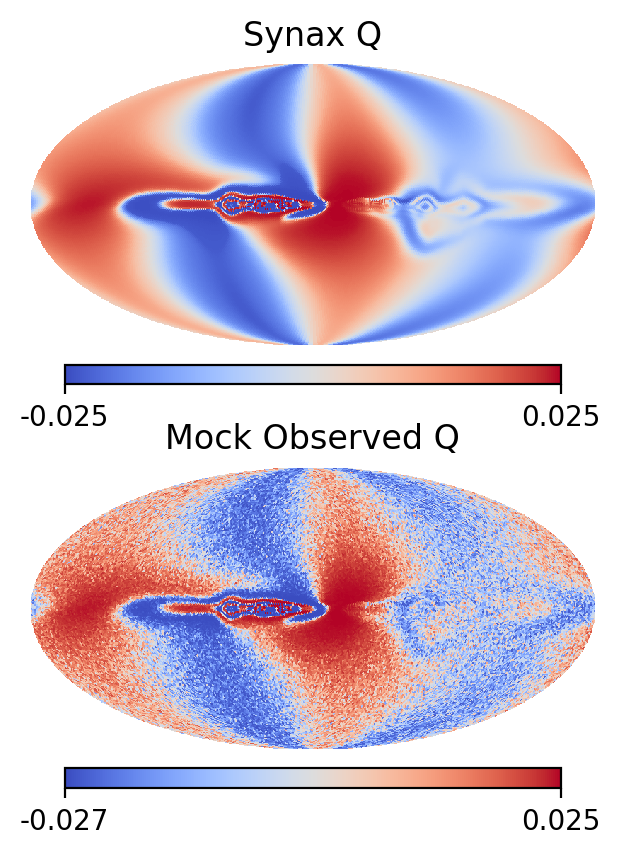

In [12]:
plt.figure(dpi=200)
np.random.seed(42)
plt.subplot(211)
hp.mollview(Sync_Q_ints[0],format='%.2g',norm='hist',cmap='coolwarm',hold=True,title='Synax Q')

plt.subplot(212)
hp.mollview(Sync_Q_ints[0]+np.random.randn(Sync_Q_ints[0].shape[0])*0.001,format='%.2g',norm='hist',cmap='coolwarm',hold=True,title='Mock Observed Q')

plt.savefig("lsa_sim.pdf",bbox_inches='tight',dpi=200)

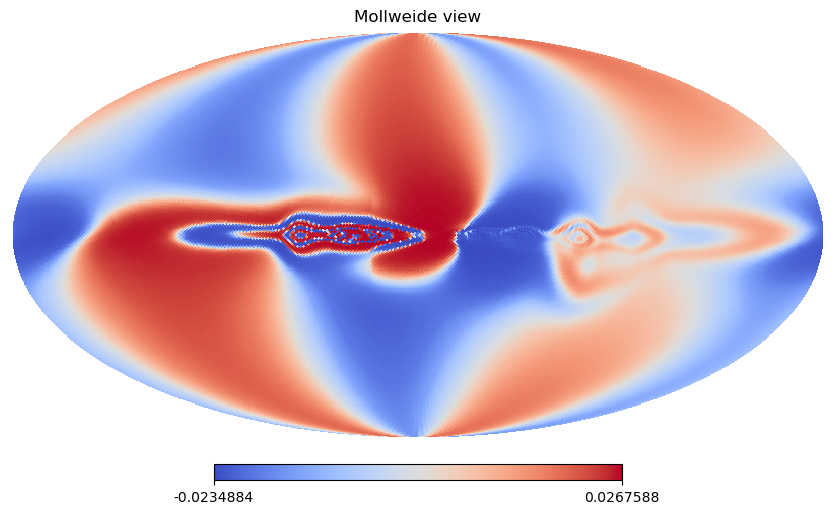

In [13]:
hp.mollview(Sync_U_ints[0],norm='hist',cmap='coolwarm')

In [14]:
np.save('Sim_lsa.npy',np.array([Sync_Q_ints,Sync_U_ints]))